In [1]:
import pickle
import numpy as np
import numba
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from librosa.sequence import dtw
from matplotlib import gridspec
from speechCommon import *
import time
import os

In [2]:
user = 'agoutam'

hyp_dir = '/home/{}/ttemp/TamperingDetection/hyp'.format(user)
all_ids = '/home/{}/ttemp/TamperingDetection/data/cfg_files/all.ids'.format(user)
train_ids = '/home/{}/ttemp/TamperingDetection/data/cfg_files/train.ids'.format(user)

editTimeSec = 2

In [3]:
# def readMFCC(query_id, edit_type='n', piece=1, mfcc_type='old'):
#     ref_file_dir = '../ttemp/TamperingDetection/data/mfcc/reference/{}.pkl'.format(query_id.replace("_160", ""))
#     query_file_dir = '../ttemp/TamperingDetection/data/mfcc/queries/160kbps/2sec/{}_{}{}.pkl'.format(query_id, edit_type, piece)
#     with open(ref_file_dir, 'rb') as f:
#         d = pickle.load(f)
#         ref_mfcc = d[mfcc_type]
#     with open(query_file_dir, 'rb') as f:
#         d = pickle.load(f)
#         query_mfcc = d[mfcc_type]

#     return ref_mfcc.T[:,:12], query_mfcc.T[:,:12]

In [4]:
def readMFCC(query_id, edit_type = 'n', piece = '1'):
    mfcc_ref = getMFCC(query_id, time = editTimeSec)
    print('got ref')
    mfcc_query = getMFCC(query_id, time = editTimeSec, piece_type="queries", edit_type=edit_type+str(piece))
    print('got query')
    
    return mfcc_ref, mfcc_query

In [5]:
def dist(query_id, edit_type, piece):
    mfcc_ref, mfcc_query = readMFCC(query_id, edit_type=edit_type, piece=piece)
    C = euclidean_distances(mfcc_query, mfcc_ref)
    return C

In [6]:
@numba.jit(nopython=True)
def DP(C, beta=0.001):
    # 0: visible, 1: hidden
    # B: 1 Diag, 2 Right, 3 Up, 0 hidden -> visible
    # initialization
    D = np.zeros((2, C.shape[0], C.shape[1]))
    M = np.zeros((2, C.shape[0], C.shape[1]))
    N = np.zeros((2, C.shape[0], C.shape[1]))
    SS = np.zeros((2, C.shape[0], C.shape[1]))
    B = np.zeros((2, C.shape[0], C.shape[1]))
    
    # bottom rows
    D[0, 0, :] = C[0, :]
    D[1, 0, :] = np.inf
    M[0, 0, :] = C[0, :]
    M[1, 0, :] = np.inf
    N[0, 0, :] = 1
    
    # first cols
    D[:, 1:, 0] = np.inf
    B[:, 1:, 0] = 1  # doesn't matter
    N[:, 1:, 0] = 1  # doesn't matter
    M[:, 1:, 0] = 1  # doesn't matter
    SS[:, 1:, 0] = 1  # doesn't matter
        
    # rest of the matrix
    for i in range(1, C.shape[0]):
        for j in range(1, C.shape[1]):
        
            # hidden
            costs = np.array([D[0, i-1, j-1], D[1, i, j-1], D[1, i-1, j]])
            D[1, i, j] = np.min(costs)
            B[1, i, j] = np.argmin(costs) + 1
            
            if B[1, i, j] == 1:  # diag visible -> hidden
                M[1, i, j] = M[0, i-1, j-1]
                N[1, i, j] = N[0, i-1, j-1]
                SS[1, i, j] = SS[0, i-1, j-1]
            elif B[1, i, j] == 2:  # right
                M[1, i, j] = M[1, i, j-1]
                N[1, i, j] = N[1, i, j-1]
                SS[1, i, j] = SS[1, i, j-1]
            elif B[1, i, j] == 3:  # up
                M[1, i, j] = M[1, i-1, j]
                N[1, i, j] = N[1, i-1, j]
                SS[1, i, j] = SS[1, i-1, j]
                
            # visible
            # option1: diag in visible plane
            N_cand1 = N[0, i-1, j-1] + 1
            M_cand1 = (M[0, i-1, j-1] * N[0, i-1, j-1] + C[i, j]) / N_cand1
            SS_cand1 = SS[0, i-1, j-1] + (C[i, j] - M[0, i-1, j-1]) * (C[i, j] - M_cand1)
            D_cand1 = M_cand1 * N_cand1 / np.max(np.array([beta, np.sqrt(SS_cand1 / (N_cand1-1))]))
        
            # option2: hidden -> visible plane
            N_cand2 = N[1, i, j] + 1
            M_cand2 = (M[1, i, j] * N[1, i, j] + C[i, j]) / N_cand2
            SS_cand2 = SS[1, i, j] + (C[i, j] - M[1, i, j]) * (C[i, j] - M_cand2)
            D_cand2 = M_cand2 * N_cand2 / np.max(np.array([beta, np.sqrt(SS_cand2 / (N_cand2-1))]))
            
            #print(D_cand1, D_cand2)
            if D_cand1 < D_cand2:
                M[0, i, j] = M_cand1
                N[0, i, j] =  N_cand1
                SS[0, i, j] = SS_cand1
                B[0, i, j] = 1
                D[0, i, j] = D_cand1
            else:
                M[0, i, j] = M_cand2
                N[0, i, j] =  N_cand2
                SS[0, i, j] = SS_cand2
                B[0, i, j] = 0
                D[0, i, j] = D_cand2
    return B, D

In [7]:
@numba.jit(nopython=True)
def NWTWDP(C, gap, beta=20):
    # 0: visible, 1: hidden
    # B: 1 Diag, 2 Right, 3 Up, 0 switch plane
    # initialization
    D = np.zeros((2, C.shape[0], C.shape[1]))
    B = np.zeros((2, C.shape[0], C.shape[1]))
    
    # bottom rows
    D[0, 0, :] = C[0, :]
    D[1, 0, :] = np.inf
    
    # first cols
    for i in range(1, C.shape[0]):
        D[0, i, 0] = D[0, i-1, 0] + gap
        D[1, i, 0] = D[0, i, 0]
        B[0, i, 0] = 3
        B[1, i, 0] = 0
        
    # rest of the matrix
    for i in range(1, C.shape[0]):
        for j in range(1, C.shape[1]):
        
            # hidden
            # diag visible -> hidden, right in hidden, up in hidden
            costs = np.array([D[0, i-1, j-1] + 1 + gap, np.inf, D[1, i, j-1] + 1, D[1, i-1, j] + gap])
            D[1, i, j] = np.min(costs)
            B[1, i, j] = np.argmin(costs)
                
            # visible
            # hidden -> visible, diag
            costs = np.array([D[1, i, j] + beta, D[0, i-1, j-1] + C[i, j]])
            D[0, i, j] = np.min(costs)
            B[0, i, j] = np.argmin(costs)
            
    return B, D

In [8]:
#@numba.jit(nopython=True)
def backtrace(B, D):
    p = 0
    r = D.shape[1] - 1
    c = np.argmin(D[0, -1])
    path_v = []
    path_h = []
    while r > 0:
        if p == 0:
            path_v.append([r, c])
        else:
            path_h.append([r, c])
        if B[p, r, c] == 0 and p == 0:
            p = 1
            r -= 1
            c -= 1
        elif B[p, r, c] == 0 and p == 1:
            p = 0
        elif B[p, r, c] == 1:
            r -= 1
            c -= 1
        elif B[p, r, c] == 2:
            c -= 1
        elif B[p, r, c] == 3:
            r -= 1
    return np.asarray(path_v), np.asarray(path_h)

In [9]:
#@numba.jit(nopython=True)
def backtrace3D(B, D):
    p = 0
    r = D.shape[1] - 1
    c = np.argmin(D[0, -1])
    path_3D = []
    while r > 0:
        path_3D.append([p,r,c])
        if B[p, r, c] == 0 and p == 0:
            p = 1
            r -= 1
            c -= 1
        elif B[p, r, c] == 0 and p == 1:
            p = 0
        elif B[p, r, c] == 1:
            r -= 1
            c -= 1
        elif B[p, r, c] == 2:
            c -= 1
        elif B[p, r, c] == 3:
            r -= 1
    return np.asarray(path_3D)

In [10]:
def alignNWTWDP(query_id, edit_type, piece, Cb):
    
    C = dist(query_id, edit_type, piece)
    gap = np.median(np.min(C, axis=1)) * 3
    B, D = NWTWDP(C, gap, beta=(gap+1)*Cb)
    path_v, path_h = backtrace(B, D)
    return path_v, path_h, C

In [11]:
def alignNWTWDP3D(query_id, edit_type, piece, Cb):
    
    C = dist(query_id, edit_type, piece)
    gap = np.median(np.min(C, axis=1)) * 3
    B, D = NWTWDP(C, gap, beta=(gap+1)*Cb)
    path_3D = backtrace3D(B, D)
    return path_3D, C

In [12]:
def alignDTW(query_id, edit_type, piece, weightSet = 'D1'):
    mfcc_ref, mfcc_query = readMFCC(query_id, edit_type=edit_type, piece=piece)
    D, wp = dtw(mfcc_query.T, mfcc_ref.T, subseq=True, step_sizes_sigma=sigma, weights_mul=dtw_weights[weightSet])
    return wp

In [13]:
def concatPaths(path_v, path_h):
    if(path_v.shape[0] == 0):
        return path_h
    if(path_h.shape[0] == 0):
        return path_v
    
    bothPaths = np.vstack((path_v, path_h))
    pathOrder = np.argsort(bothPaths[:,0])
    completePath = bothPaths[pathOrder]
    return completePath[::-1]

In [14]:
startTime = time.time()
query_id = '12_2_17'
edit_type = 'r'
piece = 8
path_v, path_h, C = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)
print(time.time() - startTime)

got ref
got query
got ref
got query
5.294332265853882


In [15]:
startTime = time.time()
query_id = '12_2_17'
edit_type = 'r'
piece = 8
path_3D, C = alignNWTWDP3D(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)
print(time.time() - startTime)

got ref
got query
got ref
got query
3.547907590866089


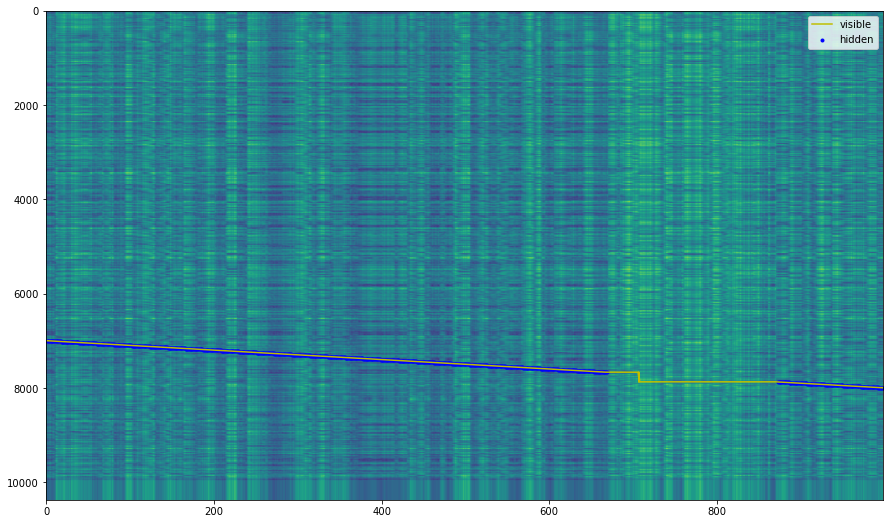

In [16]:
shifter = 0

plt.figure(figsize = (15,9))
plt.imshow(C.T, aspect = 'auto')
plt.scatter(path_v[:,0], path_v[:,1], color = 'b', marker = '.')
#plt.scatter(path_h[:,0], path_h[:,1], color = 'r', marker = '.')
bothPaths = concatPaths(path_v, path_h)
plt.plot(bothPaths[:,0], bothPaths[:,1], 'y', )
plt.legend(['visible','hidden'])
plt.show()

In [19]:
def alignAndSave(query_id, editTimeSec, edit_type, piece):
    if query_id == '00' or piece in [11, 12, 13]:
        
        return
    filename = '{}/{}sec/{}/{}_{}{}.pkl'.format(hyp_dir, editTimeSec, 'HSTW', query_id, edit_type, piece)
    print((hyp_dir, editTimeSec, 'HSTW' ,query_id, edit_type, piece))
    print(filename)
    if not os.path.exists(filename):
    #if True:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        path_3D, C = alignNWTWDP3D(query_id, edit_type, piece, Cb = 7)
        
        elem = path_3D[0]
        prevPlane = elem[0]
        costs = [C[elem[1], elem[2]]]
        for elem in path_3D[1:]:
            curPlane = elem[0]
            if(curPlane == 0 and prevPlane == 1):
                continue
            else:
                costs.append(C[elem[1], elem[2]])
                
        res = {}
        res['wp'] = path_3D
        res['dist'] = np.asarray(costs)
        res['size'] = C.shape
        with open(filename, 'wb') as f:
            pickle.dump(res, f)

In [ ]:
total = 0

with open ('/home/{}/ttemp/TamperingDetection/cfg_files/train.ids'.format(user), 'r') as f:
    for i, query_id in enumerate(f.read().split('\n')):
        if(query_id == ''):
            continue
        print(i, query_id)
        for edit_type in ['i']:
            for piece in range(1, 11):
                filename = '{}/{}sec/{}/{}_{}{}.pkl'.format(hyp_dir, editTimeSec, 'HSTW', query_id, edit_type, piece)
                if not os.path.exists(filename):
                    print('aligning', query_id, edit_type, piece)
                    alignAndSave(query_id, editTimeSec, edit_type, piece)
                    total += 1

0 10_6_17
aligning 10_6_17 i 1
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '10_6_17', 'i', 1)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/10_6_17_i1.pkl
got ref
got query
aligning 10_6_17 i 2
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '10_6_17', 'i', 2)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/10_6_17_i2.pkl
got ref
got query
aligning 10_6_17 i 3
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '10_6_17', 'i', 3)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/10_6_17_i3.pkl
got ref
got query
aligning 10_6_17 i 4
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '10_6_17', 'i', 4)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/10_6_17_i4.pkl
got ref
got query
aligning 10_6_17 i 5
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '10_6_17', 'i', 5)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/10_6_17_i5.pkl
got ref
got query
aligning 10_6_17 i 6
('/home/agoutam/ttemp/TamperingDetection/hyp', 2,

got ref
got query
aligning 12_30_17 i 5
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '12_30_17', 'i', 5)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/12_30_17_i5.pkl
got ref
got query
aligning 12_30_17 i 6
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '12_30_17', 'i', 6)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/12_30_17_i6.pkl
got ref
got query
aligning 12_30_17 i 7
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '12_30_17', 'i', 7)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/12_30_17_i7.pkl
got ref
got query
aligning 12_30_17 i 8
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '12_30_17', 'i', 8)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/12_30_17_i8.pkl
got ref
got query
aligning 12_30_17 i 9
('/home/agoutam/ttemp/TamperingDetection/hyp', 2, 'HSTW', '12_30_17', 'i', 9)
/home/agoutam/ttemp/TamperingDetection/hyp/2sec/HSTW/12_30_17_i9.pkl
got ref
got query
aligning 12_30_17 i 10
('/home/agoutam/ttemp/Ta

### (Works up till here)

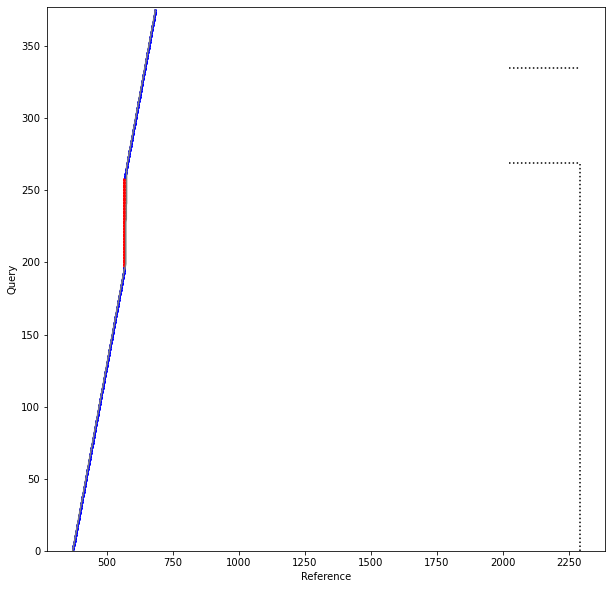

In [13]:
# insertion wrong
query_id = '12_30_17'
edit_type = 'i'
piece = 6
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(2023, 2291):
    path1.append([269, i])
path1 = np.array(path1)
path2 = []
for i in range(2023, 2291):
    path2.append([335, i])
path2 = np.array(path2)
path3 = []
for i in range(0, 269):
    path3.append([i, 2291])
path3 = np.array(path3)

plt.figure(figsize=(10, 10))#had dpi = 180
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 377) 
#plt.xlim(2023, 2335) 
plt.show()

Text(0, 0.5, 'Query')

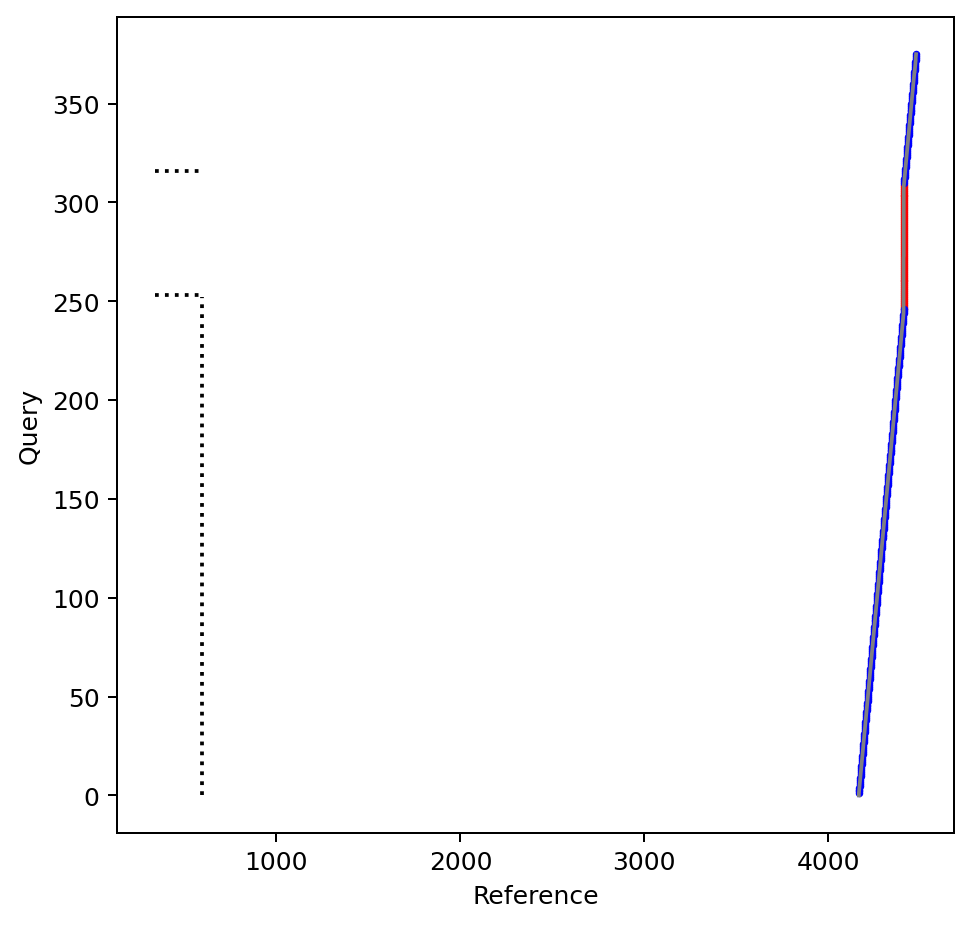

In [21]:
# insertion correct
query_id = '10_6_17'
edit_type = 'i'
piece = 3
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(341, 594):
    path1.append([316, i])
path1 = np.array(path1)
path2 = []
for i in range(341, 594):
    path2.append([253, i])
path2 = np.array(path2)
path3 = []
for i in range(0, 253):
    path3.append([i, 594])
path3 = np.array(path3)

plt.figure(figsize=(6, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
#plt.ylim(0, 375) 
#plt.xlim(341, 652) 

(2251.0, 2563.0)

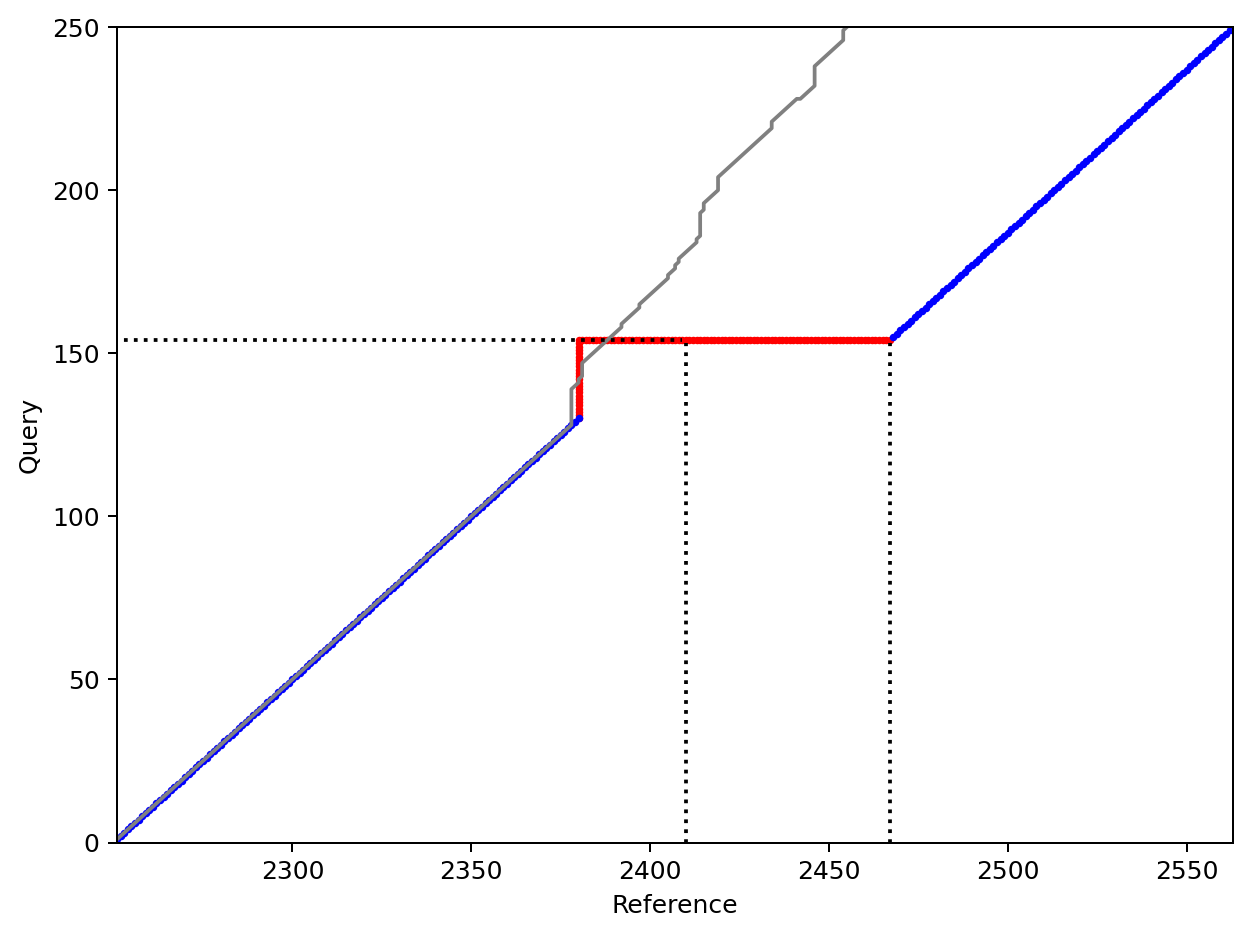

In [45]:
# deletion correct
query_id = '2_10_17'
edit_type = 'd'
piece = 8
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 154):
    path1.append([i, 2467])
path1 = np.array(path1)
path2 = []
for i in range(0, 154):
    path2.append([i, 2410])
path2 = np.array(path2)
path3 = []
for i in range(0, 2410):
    path3.append([154, i])
path3 = np.array(path3)


plt.figure(figsize=(8, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 250) 
plt.xlim(2251, 2563) 

(645.0, 957.0)

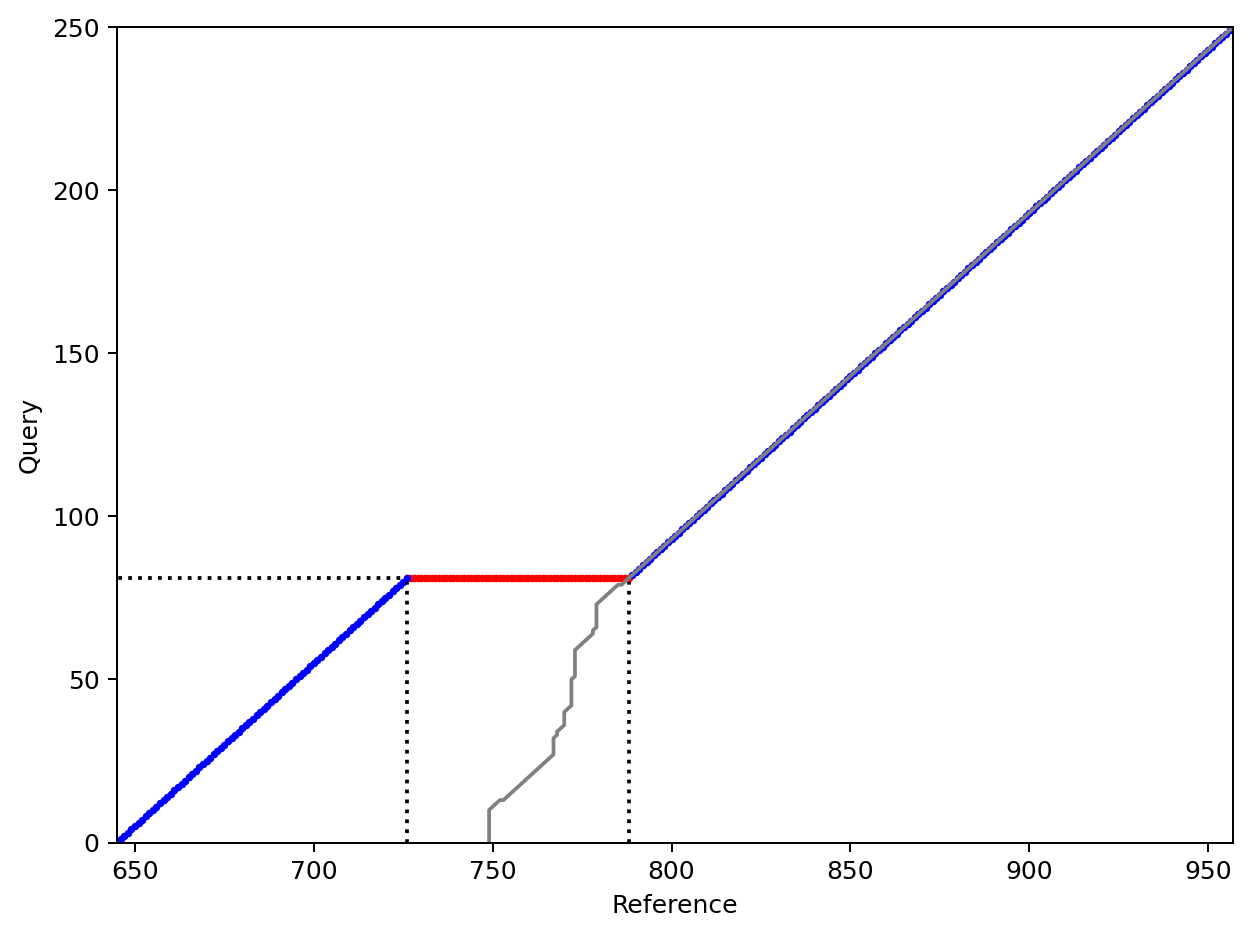

In [44]:
# deletion correct
query_id = '10_6_17'
edit_type = 'd'
piece = 8
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 81):
    path1.append([i, 788])
path1 = np.array(path1)
path2 = []
for i in range(0, 81):
    path2.append([i, 726])
path2 = np.array(path2)
path3 = []
for i in range(0, 726):
    path3.append([81, i])
path3 = np.array(path3)


plt.figure(figsize=(8, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 250) 
plt.xlim(645, 957) 

(139.0, 451.0)

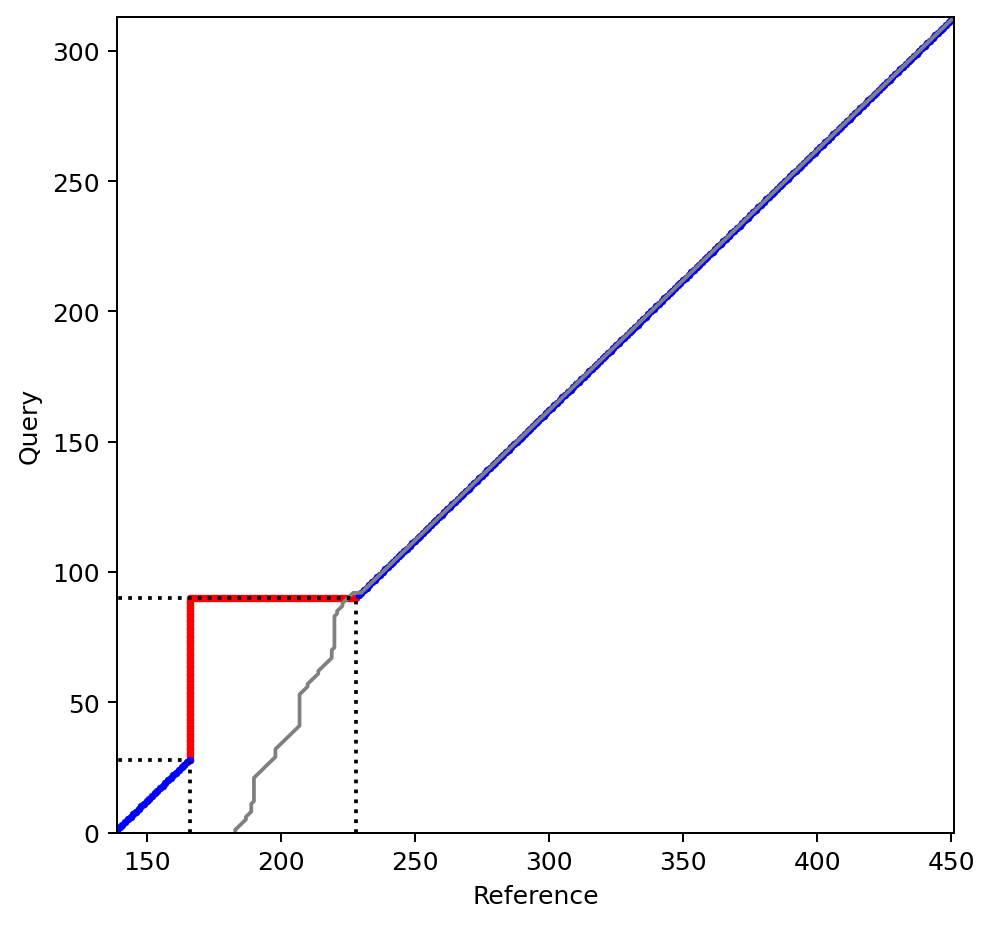

In [43]:
# replacement correct
query_id = '10_6_17'
edit_type = 'r'
piece = 6
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 28):
    path1.append([i, 166])
path1 = np.array(path1)
path2 = []
for i in range(0, 90):
    path2.append([i, 228])
path2 = np.array(path2)

path3 = []
for i in range(0, 166):
    path3.append([28, i])
path3 = np.array(path3)
path4 = []
for i in range(0, 228):
    path4.append([90, i])
path4 = np.array(path4)

plt.figure(figsize=(6, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.plot(path4[:,1], path4[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 313) 
plt.xlim(139, 451) 

(139.0, 288.0)

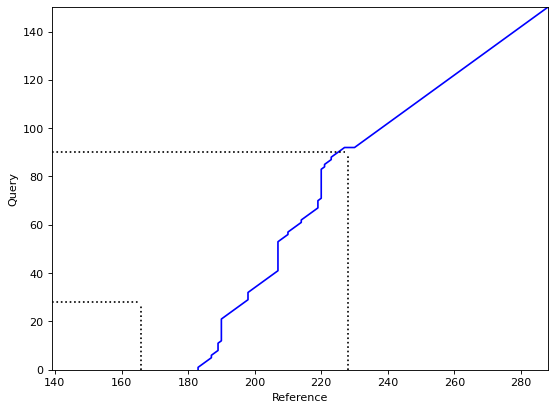

In [159]:
query_id = '10_6_17'
edit_type = 'r'
piece = 6
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 28):
    path1.append([i, 166])
path1 = np.array(path1)
path2 = []
for i in range(0, 90):
    path2.append([i, 228])
path2 = np.array(path2)

path3 = []
for i in range(0, 166):
    path3.append([28, i])
path3 = np.array(path3)
path4 = []
for i in range(0, 228):
    path4.append([90, i])
path4 = np.array(path4)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='blue')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.plot(path4[:,1], path4[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 150) 
plt.xlim(139, 288) 

(1997.0, 2308.0)

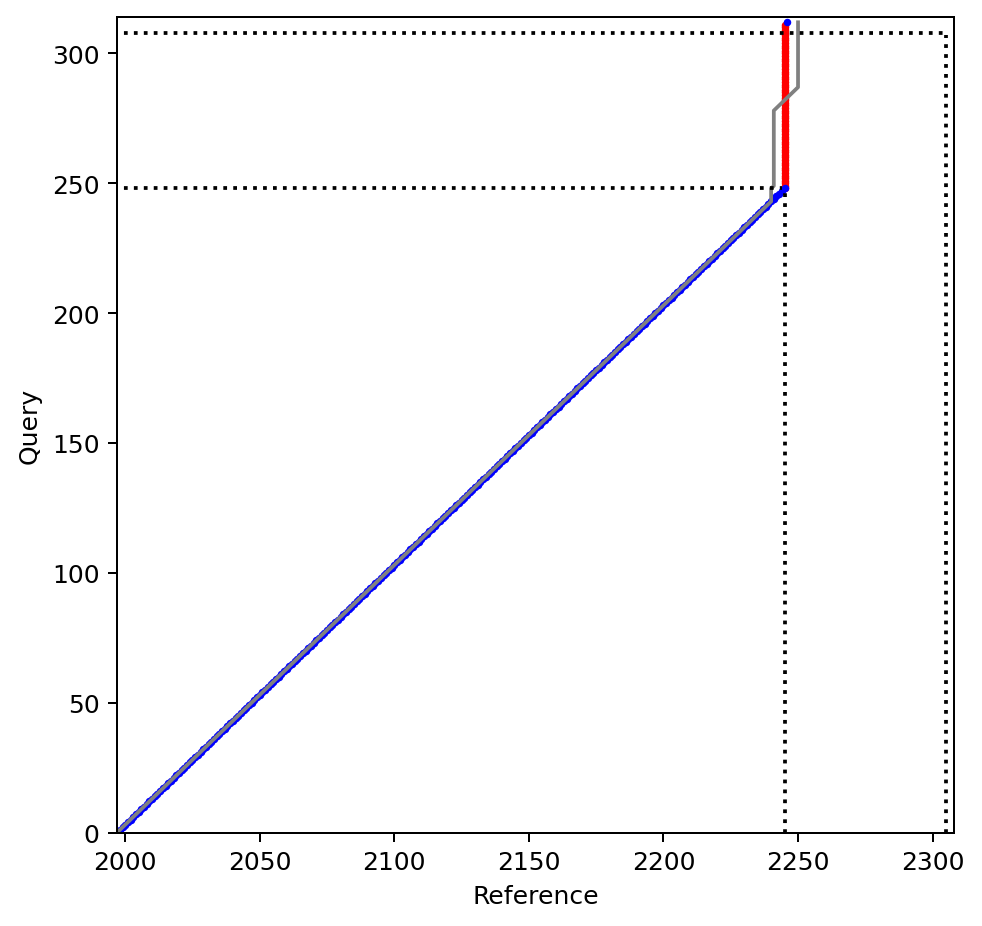

In [42]:
# replacement wrong
query_id = '10_6_17'
edit_type = 'r'
piece = 3
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 248):
    path1.append([i, 2245])
path1 = np.array(path1)
path2 = []
for i in range(0, 308):
    path2.append([i, 2305])
path2 = np.array(path2)

path3 = []
for i in range(0, 2245):
    path3.append([248, i])
path3 = np.array(path3)
path4 = []
for i in range(0, 2305):
    path4.append([308, i])
path4 = np.array(path4)

plt.figure(figsize=(6, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.plot(path4[:,1], path4[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 314) 
plt.xlim(1997, 2308) 

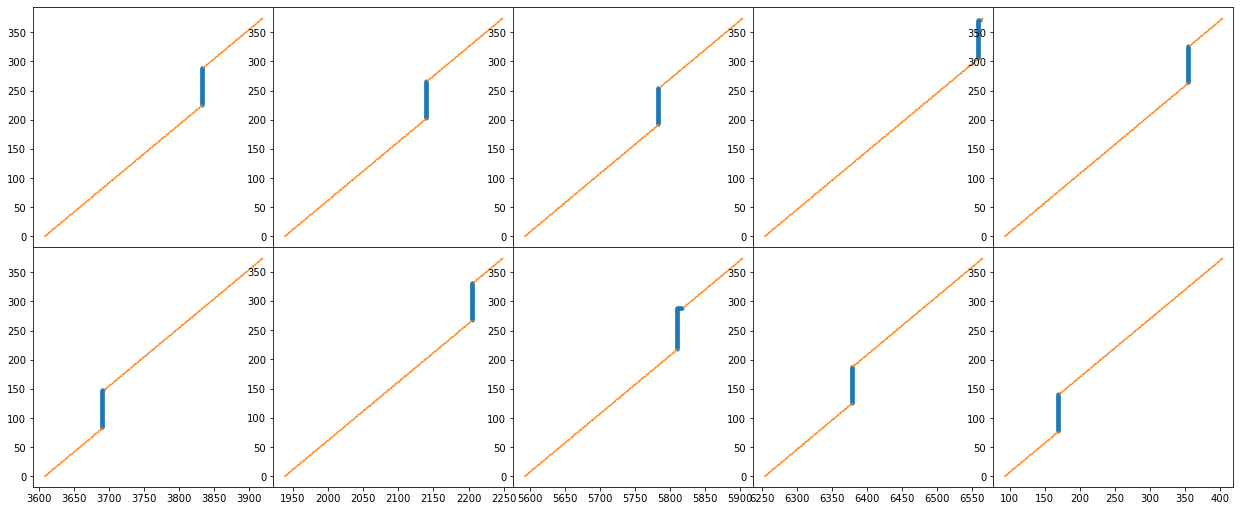

In [104]:
query_id = '3_25_17'
edit_type = 'i'
fig = plt.figure(figsize=(20, 10)) 
nrow = 2
ncol = 5
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i,j])
        piece = i * 5 + j + 1
        path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 7)
        plt.scatter(path_h[:, 1], path_h[:, 0], s=3**2)
        plt.scatter(path_v[:, 1], path_v[:, 0], s=0.5**2)
        #ax.set_xticklabels([])
        #ax.set_yticklabels([])